## NB developing and testing basic architecture

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from torch.nn import CrossEntropyLoss #, NLLLoss, BCELoss

## PYTORCH GEOMETRIC VERSION 2.2.0

In [2]:
p = '13bar'
dataset_file = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/{p}/dataset_{p}_graph_nn_all.pt'
# dataset_file = '/mnt/lustre/scratch/nlsas/home/usc/ie/mpm/NEXT100/data/pressure_topology/{p}/graph_nn_all_connected_{p}_4k.pt'

dataset = torch.load(dataset_file.format(p = p))
train_dataset, val_dataset, test_dataset = dataset

In [3]:
batch_size = 64

# Shuffle and create DataLoader for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
import sys
sys.path.append('/home/usc/ie/mpm/NEXT_graphs')
from NEXT_graphNN.utils.data_loader import edge_tensor

In [4]:
# def edge_tensor(*args):
#     '''
#     Function to join edge_attr and edge_weight if the PyTorch layer only takes one and it is only
#     for deleting some (like in TopKPooling, where I've found that it only takes edge_attr as input
#     but doesn't do anything to it more than deleting some connections, so I join both just to delete
#     also the weight tensor; if the function returned a mask I'd use that better, but...)
#     Also, if a joined tensor (previously returned by this function) is given, it splits again
#     into the attr and weights.
#     '''
#     if len(args) == 1: 
#         tensor = args[0]
#         if isinstance(tensor, torch.Tensor):
#             return tensor[:, :2], tensor[:, -1]
#         else:
#             raise ValueError("Input should be a tensor.")
#     elif len(args) == 2:  
#         tensor1, tensor2 = args
#         if isinstance(tensor1, torch.Tensor) and isinstance(tensor2, torch.Tensor):
#             return torch.cat((tensor1, tensor2.unsqueeze(1)), dim=1)
#         else:
#             raise ValueError("Both inputs should be tensors.")
#     else:
#         raise ValueError("Expected either 1 or 2 tensors as input.")

### ME ESTOY DANDO CUENTA DE QUE EN NINGUN MOMENTO AQUI TENEMOS EFECTO DE LOS EDGE ATTRIBUTES YA QUE HACEMOS CONVOLUCION SOLO PENSANDO EN NODOS Y EDGE WEIGHTS, LUEGO EL POOLING SOLO TIENE COMO INPUT EDGE_ATTR PARA FILTRARLOS, TIPO DESHACERNOS DE LOS QUE YA NO EXISTEN PORQUE ELIMINAMOS SUS NODOS, Y NADA MAS

### HABRA FORMA DE HACER COMO UN POOLING THE LOS EDGES AL MISMO TIEMPO Y QUE DE INFORMACION? PORQUE DE CONVOLUTION NO PARECE, SOLO PARECE QUE LOS WEIGHTS DAN INFO

### VALE SI, HAY CONVOLUCIONES (GRAPH ATTENTION, PRINCIPAL NEIGHBOURHOOD AGG) QUE TIENEN EN CUENTA LOS EDGES PARECE :)

In [5]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
# from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
# from torch_geometric.nn import BatchNorm

# from NEXT_graphNN.networks.blocks import ConvNormBlock, FullyConnectedLinearBlock
from NEXT_graphNN.networks.architectures import GCNClass, PoolGCNClass


In [ ]:
# #bloque en el que se hace una convolucion y una normalización duplicando el numero de features
# class ConvNormBlock(torch.nn.Module):
#     '''
#     Graph Convolution and Batch Normalization block. The input features are multiplied by a factor to get the output dimension.
#     '''
#     def __init__(self, input_dim, mult_features = 2):
#         torch.nn.Module.__init__(self)
#         self.output_dim = mult_features * input_dim

#         self.conv1 = GCNConv(input_dim, self.output_dim)
#         self.bnr1  = BatchNorm(self.output_dim)
    
#     def forward(self, x, edge_index, edge_weight):
#         x = self.conv1(x, edge_index, edge_weight)
#         x = self.bnr1(x)
#         return x
    
#     def output_dim(self):
#         return self.output_dim

# class FullyConnectedLinearBlock(torch.nn.Module):
#     def __init__(self, input_dim, output_dim, p = 0.5):
#         torch.nn.Module.__init__(self)
#         self.p   = p
#         self.fc1 = nn.Linear(input_dim, input_dim)
#         self.fc2 = nn.Linear(input_dim, output_dim)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, p = self.p)
#         x = self.fc2(x)
#         return x

In [ ]:
# class GCNClass(torch.nn.Module):
#     def __init__(self, input_dim, output_dim, nconv, mult_feat_per_conv = 2, dropout_prob = 0.5):
#         super(GCNClass, self).__init__()
#         self.nconv = nconv
#         self.dropout_prob = dropout_prob
#         self.convnorm, self.linears = torch.nn.ModuleList([]), torch.nn.ModuleList([])

#         self.linears.append(FullyConnectedLinearBlock(input_dim, output_dim, p = dropout_prob))
        
#         for i in range(nconv):
#             self.convnorm.append(ConvNormBlock(input_dim, mult_features = mult_feat_per_conv))
#             self.linears.append(FullyConnectedLinearBlock(self.convnorm[-1].output_dim, input_dim, p = dropout_prob))
#             input_dim = self.convnorm[-1].output_dim

#     def forward(self, data):
#         x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_weight, data.batch

#         for i in range(self.nconv):
#             x = F.relu(self.convnorm[i](x, edge_index, edge_weight))
#             x = F.dropout(x, p = self.dropout_prob)
#         x = global_mean_pool(x, batch)

#         for lin in self.linears[::-1]:
#             x = lin(x)
#         # x = F.log_softmax(x, dim = 1)
#         return x
    
# class PoolGCNClass(torch.nn.Module):
#     def __init__(self, input_dim, output_dim, npool, mult_feat_per_conv = 2, pool_ratio = 0.8, dropout_prob = 0.5):
#         super(PoolGCNClass, self).__init__()
#         self.npool = npool
#         self.dropout_prob = dropout_prob

#         self.convnorm, self.pools, self.linears = torch.nn.ModuleList([]), torch.nn.ModuleList([]), torch.nn.ModuleList([])

#         self.convnorm.append(ConvNormBlock(input_dim, mult_features = mult_feat_per_conv))
#         input_dim = self.convnorm[-1].output_dim
#         self.linears.append(FullyConnectedLinearBlock(input_dim, output_dim, p = dropout_prob))
        
#         for i in range(npool):
#             self.pools.append(TopKPooling(input_dim, ratio = pool_ratio))
#             self.convnorm.append(ConvNormBlock(input_dim, mult_features = mult_feat_per_conv))
#             self.linears.append(FullyConnectedLinearBlock(self.convnorm[-1].output_dim, input_dim, p = dropout_prob))
#             input_dim = self.convnorm[-1].output_dim

#     def forward(self, data):
#         x, edge_index, edge_attr, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.edge_weight, data.batch

#         for i in range(self.npool):
#             x = F.relu(self.convnorm[i](x, edge_index, edge_weight))
#             x = F.dropout(x, p = self.dropout_prob) 
#             edge_info = edge_tensor(edge_attr, edge_weight)
#             x, edge_index, edge_info, batch, _, _ = self.pools[i](x, edge_index, edge_info, batch)
#             edge_attr, edge_weight = edge_tensor(edge_info)
        
#         x = F.relu(self.convnorm[-1](x, edge_index, edge_weight))
#         x = global_mean_pool(x, batch)

#         for lin in self.linears[::-1]:
#             x = lin(x)

#         # I think that for cross entropy loss it takes the output of the network as it is, without any softmax function
#         # Then, the softmax would be needed if I wanted the probability of each class, but just for the accuracy using argmax would have the same results with or without the softmax
#         # x = F.log_softmax(x, dim = 1)
#         return x

In [6]:
all_data = list(train_loader)
batch = all_data[0]

In [7]:
def get_grads(model):
    names, grad_val = [], []
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            names.append(name)
            grad_val.append(param.grad.abs().mean().item())
    return names, grad_val

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    return lr

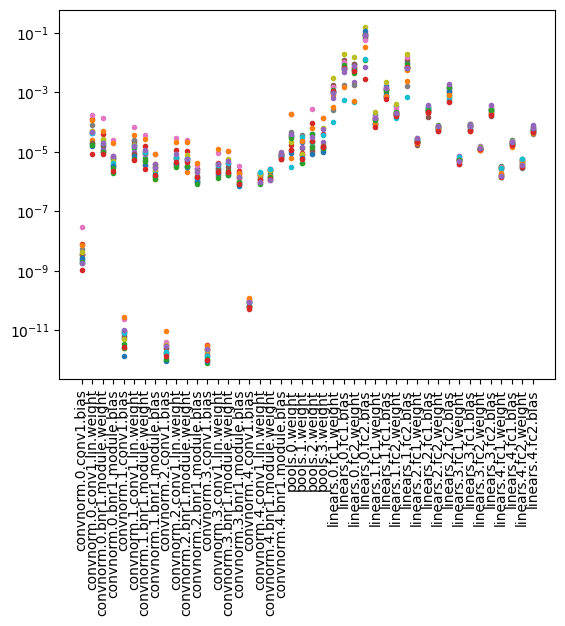

In [8]:
model = PoolGCNClass(4, 2, 4)
loss_fn = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for i, batch in enumerate(all_data[:15]):
    optimizer.zero_grad()
    out = model.forward(batch) 
    label = torch.reshape(torch.tensor(batch['binclass'], dtype = torch.long), (-1,))
    loss = loss_fn(out, label)
    loss.backward()
    optimizer.step()

    names, grad_val = get_grads(model)
    
    plt.plot(names, grad_val, '.')
    plt.xticks(rotation = 90)
    plt.yscale('log')

In [7]:
import sys
from enum import auto
from invisible_cities.types.ic_types import AutoNameEnumBase
from NEXT_graphNN.utils.data_loader import LabelType
from NEXT_graphNN.utils.train_utils import Metrics, train_one_epoch, valid_one_epoch

In [19]:
# class LabelType(AutoNameEnumBase):
#     Classification = auto()
#     Segmentation   = auto()

# class Metrics():
#     def __init__(self, labeltype, nclass = 3):
#         super(Metrics, self).__init__()

#         def accuracy(true, pred):
#             acc = sum(true == pred) / len(true)
#             return acc

#         def IoU(true, pred, nclass = nclass):
#             """
#             Intersection over union is a metric for semantic segmentation.
#             It returns a IoU value for each class of our input tensors/arrays.
#             It is inside the init of the class so that we have already the desired
#             nclass from the moment we create the class
#             """
#             eps = sys.float_info.epsilon
#             confusion_matrix = np.zeros((nclass, nclass))

#             for i in range(len(true)):
#                 confusion_matrix[true[i]][pred[i]] += 1

#             iou = []
#             for i in range(nclass):
#                 iou.append((confusion_matrix[i, i] + eps) / (sum(confusion_matrix[:, i]) + sum(confusion_matrix[i, :]) - confusion_matrix[i, i] + eps))
#             return np.array(iou)
        
#         if labeltype == LabelType.Classification:
#             self.label_name = 'binclass'
#             self.met_epoch  = 0
#             self.metric_fn  = accuracy

#         elif labeltype == LabelType.Segmentation:
#             self.label_name = 'y'
#             self.met_epoch  = np.zeros(nclass)            
#             self.metric_fn  = IoU

In [35]:
# def train_one_epoch(epoch_id, model, loader, device, optimizer, loss_fn, label_type = LabelType.Classification, nclass = 2):
#     # Tell the model it's going to train
#     model.train()
#     loss_epoch = 0
#     metrics = Metrics(label_type, nclass = nclass)
#     label_name, met_epoch, metric_fn = metrics.label_name, metrics.met_epoch, metrics.metric_fn

#     # Iterate for the batches in the data loader
#     for batch in loader:
#         # Pass the batch to device (cuda)
#         batch = batch.to(device)

#         # 1. Zero grad the optimizer
#         optimizer.zero_grad()

#         # 2. Pass the data to the model (1)
#         out = model.forward(batch) 

#         # Now we pass the output and the labels to the loss function
#         # We will use nll_loss (negative log likelihood, useful to train C classes bc we can add weights for each class)
#         # This loss will need input (N, C) target (N); being C = num of classes, N = batch size

#         label = torch.reshape(torch.tensor(batch[label_name], dtype = torch.long), (-1,)).to(device)
#         # label = batch[label_name].type(torch.LongTensor).to(device)
#         # 3. Compute the loss (2)
#         loss = loss_fn(out, label)
#         # 4. Back propagation (compute gradients of the loss with respect to the weights in the model) (3)
#         loss.backward()
#         # 5. Gradient descent (update the optimizer) (4)
#         optimizer.step()

#         # Zero grad the optimizer (5)
#         # optimizer.zero_grad()

#         # sum loss to get at the end the average loss per epoch
#         loss_epoch += loss.item()

#         # compute the metrics
#         true = label.detach().cpu().numpy() 
#         pred = out.argmax(dim=-1).detach().cpu().numpy()
#         # pred = torch.reshape(out.argmax(dim=-1, keepdim=True), (-1,)).detach().cpu().numpy() #antes tenía esta reviravolta y no se muy bien para que
#         met_epoch += metric_fn(true, pred)

#     # average the loss for the whole epoch
#     loss_epoch = loss_epoch / len(loader)
#     met_epoch  = met_epoch  / len(loader)

#     epoch_ = f"Train Epoch: {epoch_id}"
#     loss_  = f"\t Loss: {loss_epoch:.6f}"
#     met_   = f"\t Metr: {met_epoch:.6f}"
#     print(epoch_ + loss_ + met_)
    
#     return loss_epoch, met_epoch

In [11]:
# def valid_one_epoch(model, loader, device, loss_fn, label_type = LabelType.Classification, nclass = 2):
#     # Set the model to evaluate
#     model.eval()

#     loss_epoch = 0
#     metrics = Metrics(label_type, nclass = nclass)
#     label_name, met_epoch, metric_fn = metrics.label_name, metrics.met_epoch, metrics.metric_fn

#     # Freeze the gradients
#     with torch.no_grad():
#     # Iterate for the batches in the data loader
#         for batch in loader:
#             # Put batch into device (cpu/cuda)
#             batch = batch.to(device)
#             # Pass the data through the model
#             out = model.forward(batch)
#             # Get the target
#             label = torch.reshape(torch.tensor(batch[label_name], dtype = torch.long), (-1,)).to(device)
#             # Compute the loss
#             loss = loss_fn(out, label)
#             # sum loss to get at the end the average loss per epoch
#             loss_epoch += loss.item()

#             # compute the metrics
#             true = label.detach().cpu().numpy() 
#             pred = out.argmax(dim=-1).detach().cpu().numpy()
#             met_epoch += metric_fn(true, pred)
            

#         loss_epoch = loss_epoch / len(loader)
#         met_epoch  = met_epoch / len(loader)
#         loss_  = f"\t Validation Loss: {loss_epoch:.6f}"
#         met_   = f"\t Metr: {met_epoch:.6f}"
#         print(loss_, met_)

#     return loss_epoch, met_epoch

In [8]:
batch_size = 64

# Shuffle and create DataLoader for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [35]:
# DO A PARAM SCAN FOR A SEMI FIXED MODEL (update the train and valid functions in the repository and try sending jobs, es decir, hacer un script para el scan este)
# hacer que el output se vaya guardando en un df para luego poder plotear y esas cosas, ya que no tengo aun lo de tensormierda q me va guardando todo, mirar como era :)
# try also not so many lineal transform at the end?
# try less deep neural network
# lrs = [0.0001 * 10**i for i in range(3)] #lr try values like 1e-3 and 1e-4
lrs = [0.001]
#dropout also try values like 0.1
# batch size also try values like 32 and 128
for lr in lrs:
    print('Learning rate: ', lr)
    model = GCNClass(4, 2, 4, dropout_prob=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = CrossEntropyLoss()
    for i in range(15):
        train_one_epoch(i, model, train_loader, 'cpu', optimizer, loss_fn)
        valid_one_epoch(   model, val_loader,   'cpu',            loss_fn)

Learning rate:  0.001
Train Epoch: 0	 Loss: 0.653206	 Metr: 0.606325
	 Validation Loss: 0.634353
Train Epoch: 1	 Loss: 0.612490	 Metr: 0.683469
	 Validation Loss: 0.697487
Train Epoch: 2	 Loss: 0.602359	 Metr: 0.692712
	 Validation Loss: 0.617014
Train Epoch: 3	 Loss: 0.597582	 Metr: 0.698474
	 Validation Loss: 0.636703
Train Epoch: 4	 Loss: 0.593921	 Metr: 0.702055
	 Validation Loss: 0.600143
Train Epoch: 5	 Loss: 0.593220	 Metr: 0.703421
	 Validation Loss: 0.736620
Train Epoch: 6	 Loss: 0.591856	 Metr: 0.702741
	 Validation Loss: 0.612067
Train Epoch: 7	 Loss: 0.590931	 Metr: 0.703847
	 Validation Loss: 0.591645
Train Epoch: 8	 Loss: 0.588298	 Metr: 0.705627
	 Validation Loss: 0.608491
Train Epoch: 9	 Loss: 0.590350	 Metr: 0.705852
	 Validation Loss: 0.616319
Train Epoch: 10	 Loss: 0.587249	 Metr: 0.705993
	 Validation Loss: 0.607167
Train Epoch: 11	 Loss: 0.586709	 Metr: 0.706423
	 Validation Loss: 0.652028
Train Epoch: 12	 Loss: 0.585621	 Metr: 0.707225
	 Validation Loss: 0.601857


Vale, vi que la cosa venía MAINLY del learning rate

Añadi ahora al train un scheduler para el LR a ver que tal va :)

In [9]:
from NEXT_graphNN.utils.train_utils import train_net

In [10]:
lr = 1e-3
model = GCNClass(4, 2, 4, dropout_prob = 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 3, min_lr = 1e-5)
criterion = CrossEntropyLoss()

nepoch = 30
train_batch_size = 64
valid_batch_size = 64
num_workers = 1
device = 'cpu'
checkpoint_dir = '/home/usc/ie/mpm/prueba/nn/checkpoints/'
tensorboard_dir = '/home/usc/ie/mpm/prueba/nn/logs/'

In [100]:
# train_net(nepoch           = nepoch,
#                   train_dataset    = train_dataset,
#                   valid_dataset    = val_dataset,
#                   train_batch_size = train_batch_size,
#                   valid_batch_size = valid_batch_size,
#                   num_workers      = num_workers,
#                   model            = model,
#                   device           = device,
#                   optimizer        = optimizer,
#                   criterion        = criterion,
#                   scheduler        = scheduler,
#                   checkpoint_dir   = checkpoint_dir,
#                   tensorboard_dir  = tensorboard_dir,
#                   label_type       = LabelType.Classification,
#                   nclass           = 2)

In [94]:
from NEXT_graphNN.utils.read_tensorboard import load_tensorboard_df
import glob

In [96]:
tb = load_tensorboard_df(glob.glob(tensorboard_dir + '*')[0])

In [22]:
from NEXT_graphNN.utils.train_utils import predict_gen

In [61]:
# def predict_gen(test_data, model, batch_size, device, label_type = LabelType.Classification, nclass = 2):
#     loader_test = DataLoader(test_data,
#                             batch_size = batch_size,
#                             shuffle = False,
#                             num_workers = 1,
#                             drop_last = False,
#                             pin_memory = False)
    
#     model.eval()
#     softmax = torch.nn.Softmax(dim=-1)
#     label_name = Metrics(label_type, nclass = nclass).label_name
#     with torch.autograd.no_grad():
#         for batch in loader_test:
#             batch = batch.to(device)

#             out = model.forward(batch)

#             y_pred = softmax(out).cpu().detach().numpy()

#             if label_type == LabelType.Classification:
#                 out_dict = dict(file_id    = batch.fnum.detach().cpu().numpy(), 
#                                 dataset_id = batch.dataset_id.detach().cpu().numpy(), 
#                                 binclass   = batch[label_name], #already a list 
#                                 prediction = y_pred)
                
#             elif label_type == LabelType.Segmentation:
#                 _, lengths = np.unique(batch.batch.detach().cpu().numpy(), return_counts=True)
#                 dataset_id = np.repeat(batch.dataset_id.detach().cpu().numpy(), lengths)
#                 file_id    = np.repeat(batch.fnum.detach().cpu().numpy(), lengths)
#                 binclass   = np.repeat(batch.binclass, lengths)

#                 out_dict = dict(file_id    = file_id,
#                                 dataset_id = dataset_id, 
#                                 binclass   = binclass,
#                                 coords     = batch.coords.detach().cpu().numpy(), 
#                                 energy     = batch.x[:,0].detach().cpu().numpy().flatten(), 
#                                 label      = batch[label_name].detach().cpu().numpy().flatten(), 
#                                 prediction = y_pred)
#             yield out_dict

In [69]:
pred = predict_gen(test_dataset, GCNClass(4, 3, 2), batch_size, device, label_type = LabelType.Segmentation, nclass = 3)

In [70]:
coorname = ['xbin', 'ybin', 'zbin']
# outfile = params.out_file

tname = 'EventPred'

df_total = pd.DataFrame([])
# with tb.open_file(outfile, 'w') as h5out:
for dct in pred:
    if 'coords' in dct:
        coords = dct.pop('coords')
        dct.update({c:coords[:, i] for i, c in enumerate(coorname)})
    prediction = dct.pop('prediction')
    dct.update({f'class_{i}':prediction[:, i] for i in range(prediction.shape[1])})

    df = pd.DataFrame(dct)
    df_total = df_total.append(df)

In [71]:
df_total.sort_values(['file_id', 'dataset_id'])

,file_id,dataset_id,binclass,energy,label,xbin,ybin,zbin,class_0,class_1,class_2
1673,1,14,0,0.004385,1,268,75,222,0.351076,0.291404,0.357521
1674,1,14,0,0.012116,0,268,77,221,0.370151,0.291956,0.337894
1675,1,14,0,0.002756,1,269,73,220,0.358286,0.281522,0.360192
1676,1,14,0,0.010783,0,269,74,220,0.344477,0.291066,0.364458
1677,1,14,0,0.007930,1,269,74,221,0.353390,0.280956,0.365654
...,...,...,...,...,...,...,...,...,...,...,...
3402,2000,43,0,0.008878,2,207,9,323,0.360902,0.280592,0.358506
3403,2000,43,0,0.007297,2,207,10,322,0.370151,0.291956,0.337894
3404,2000,43,0,0.005170,2,207,11,322,0.375472,0.291679,0.332849
3405,2000,43,0,0.012230,2,208,7,323,0.352319,0.281271,0.366411


Learning rate:  0.0001
Train Epoch: 0	 Loss: 0.693286	 Metr: 0.507443
	 Validation Loss: 0.685955
Train Epoch: 1	 Loss: 0.650482	 Metr: 0.632013
	 Validation Loss: 0.635587
Train Epoch: 2	 Loss: 0.630129	 Metr: 0.658557
	 Validation Loss: 0.623002
Train Epoch: 3	 Loss: 0.621432	 Metr: 0.668761
	 Validation Loss: 0.619955
Train Epoch: 4	 Loss: 0.615950	 Metr: 0.674080
	 Validation Loss: 0.612338
Train Epoch: 5	 Loss: 0.611888	 Metr: 0.677555
	 Validation Loss: 0.605953
Train Epoch: 6	 Loss: 0.607884	 Metr: 0.681304
	 Validation Loss: 0.605734
Train Epoch: 7	 Loss: 0.605387	 Metr: 0.683761
	 Validation Loss: 0.601676
Train Epoch: 8	 Loss: 0.603147	 Metr: 0.684016
	 Validation Loss: 0.600287
Train Epoch: 9	 Loss: 0.600973	 Metr: 0.686221
	 Validation Loss: 0.599174
Train Epoch: 10	 Loss: 0.598625	 Metr: 0.689144
	 Validation Loss: 0.596120
Train Epoch: 11	 Loss: 0.597736	 Metr: 0.690295
	 Validation Loss: 0.596149
Train Epoch: 12	 Loss: 0.597084	 Metr: 0.691284
	 Validation Loss: 0.596154
Train Epoch: 13	 Loss: 0.595808	 Metr: 0.691924
	 Validation Loss: 0.594684

## Ejemplo Pytorch

In [18]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, nclass):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, nclass)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(in_channels=4, hidden_channels=64, nclass = 2)
print(model)

GCN(
  (conv1): GCNConv(4, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [45]:
for batch in train_loader:  # Iterate in batches over the training dataset.
    out = model(batch.x, batch.edge_index, batch.batch)  # Perform a single forward pass.
    break

In [52]:
pred = out.argmax(dim=1)

In [59]:
model = GCN(in_channels=4, hidden_channels=64, nclass = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(loader, label_name = 'binclass'):
    model.train()

    for batch in loader:  # Iterate in batches over the training dataset.
         out = model(batch.x, batch.edge_index, batch.batch)  # Perform a single forward pass.
         loss = criterion(out, torch.tensor(batch[label_name], dtype=torch.long)) # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader, label_name = 'binclass'):
     model.eval()

     correct = 0
     for batch in loader:  # Iterate in batches over the training/test dataset.
         out = model(batch.x, batch.edge_index, batch.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == torch.tensor(batch[label_name])).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.4973, Test Acc: 0.5081
Epoch: 002, Train Acc: 0.4973, Test Acc: 0.5081
Epoch: 003, Train Acc: 0.5027, Test Acc: 0.4919
Epoch: 004, Train Acc: 0.5027, Test Acc: 0.4919


: 